In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, roc_curve, auc, cohen_kappa_score, confusion_matrix
import os
import sys
from tabulate import tabulate
from functools import reduce
from pathlib import Path
import re
parent_dir = os.path.abspath('../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)


In [6]:
from Utils import utils

# reading main config file
config = utils.read_config()

system = 2 # 1 or 2
if system == 1:
    PATH = config["Source"]["paths"]["source_path_system_1"]
elif system == 2:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    PATH = config["Source"]["paths"]["source_path_system_2"]
else:
    PATH = ""
    print("Invalid system")

In [7]:
def calculate_metrics(pred_prob, GT):
    fpr, tpr, thresholds = roc_curve(GT, pred_prob, pos_label=1)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    pred_labels = (pred_prob >= optimal_threshold).astype(int)
    #print("prediction: ", pred_labels)
    #print("GT: ", GT)

    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
    TP = ((pred_labels == 1) & (GT == 1)).sum()
    TN = ((pred_labels == 0) & (GT == 0)).sum()
    FP = ((pred_labels == 1) & (GT == 0)).sum()
    FN = ((pred_labels == 0) & (GT == 1)).sum()
    sensitivity = TP / (TP + FN)
    # precision = TP / (TP + FP)
    specificity = TN / (TN + FP)
    auc_score = auc(fpr, tpr)

    results = [
        ["True Positives (TP)", TP],
        ["True Negatives (TN)", TN],
        ["False Positives (FP)", FP],
        ["False Negatives (FN)", FN],
        ["Sensitivity", sensitivity],
        # ["Precision", precision],
        ["Specificity", specificity],
        ["AUC", auc_score]
    ]
    # Print results in tabular form
    # print(tabulate(results, headers=["Metric", "Value"], tablefmt="fancy_grid"))
    return auc_score, results

In [8]:
def best_model_selection_from_fold_metricbased(system, type, category, experiment_number, fold_number):
    repls = ("Network_Weights/best_model", "Metrics/epoch"), ("pth.tar", "csv")
    
    if type == "regression":
        path = config["Source"]["paths"][f"source_path_system_{system}"] + config["regression_path"] + f"/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    else:
        path = config["Source"]["paths"][f"source_path_system_{system}"] + config["classification_path"] + f"/{category}/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    
    model_files = []
    for dirs, subdirs, files in os.walk(path):
        for file in files:
            file_path = str(os.path.join(dirs, file))
            file_path = file_path.replace('\\','/')
            model_files.append(file_path)

    sorted(model_files)

    model_dict = dict()

          
    if type=="regression":   
        best_metric = 100000000.0
    else:
        best_metric = -1

    for model_path in model_files:
        metric_path = reduce(lambda a, kv: a.replace(*kv), repls, model_path)
        metric_data = pd.read_csv(metric_path)

        if type=="regression":   
            metric = mean_absolute_error(metric_data["GT"], metric_data["prediction (age)"])
            if metric < best_metric:
                best_metric = metric    
        else:
            if category=="Diagnosis":
                metric = cohen_kappa_score(metric_data["prediction"], metric_data["GT"])
                if metric > best_metric:
                    best_metric = metric   
            else:
                auc, _ = calculate_metrics(metric_data["prediction_probability (sex)"], np.array(metric_data["GT"]).astype(int))
                metric = auc
                if metric > best_metric:
                    best_metric = metric   

        epoch_num = model_path.split("_")[-1].split(".")[0]
        #print(metric, epoch_num, model_path)
        if metric in model_dict.keys():
            if epoch_num < model_dict[metric][1]:
                model_dict[metric] = (model_path, epoch_num)
            else:
                pass
        else:
            model_dict[metric] = (model_path, epoch_num)
          
    #print(model_dict)
    best_model_path = model_dict[best_metric][0]
    epoch_to_continue = model_dict[best_metric][1] #best_model_path.split("_")[-1].split(".")[0]
    #print("best: ", best_metric, epoch_to_continue, best_model_path)
    return best_model_path, epoch_to_continue

In [5]:
system=2
type="classification"
category="Sex"
experiment_number=2
fold_number=1
path = config["Source"]["paths"][f"source_path_system_{system}"] + config["classification_path"] + f"/{category}/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    
model_files = []
for dirs, subdirs, files in os.walk(path):
    for file in files:
        file_path = str(os.path.join(dirs, file))
        file_path = file_path.replace('\\','/')
        model_files.append(file_path)
#sorted(model_files, reverse=True)
model_files
model_files[0].split("_")[-1].split(".")[0]

'45'

In [6]:

[int(num) if num else alpha for num, alpha in re.compile(r'(\d+)|(\D+)').findall('/home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_1/Network_Weights/best_model_2.pth.tar')]

['/home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_',
 2,
 '/CV_',
 1,
 '/Network_Weights/best_model_',
 2,
 '.pth.tar']

In [7]:
tokenize = re.compile(r'(\d+)|(\D+)').findall
def natural_sortkey(string):          
    return tuple(int(num) if num else alpha for num, alpha in tokenize(string.name))

def best_model_selection_from_fold(system, type, category, experiment_number, fold_number):
    if type == "regression":
        path = config["Source"]["paths"][f"source_path_system_{system}"] + config["regression_path"] + f"/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    else:
        path = config["Source"]["paths"][f"source_path_system_{system}"] + config["classification_path"] + f"/{category}/Experiment_{experiment_number}/CV_{fold_number}/Network_Weights/"
    path_object = Path(path)
    #print(path)
    models = path_object.glob("*")
    models_sorted = sorted(models, key=natural_sortkey)
    for i in models_sorted:
        pass#print(i.name)
    best_model_path = path + [model.name for model in models_sorted][-1]
    epoch_to_continue = best_model_path.split("_")[-1].split(".")[0]
    return best_model_path, epoch_to_continue
best_model_selection_from_fold(2, 'classification', 'Sex', 2, 1)

('/home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_1/Network_Weights/best_model_92.pth.tar',
 '92')

In [12]:
def evaluate_best_models_all_folds(system, type, category, experiment_number, folds_list):
    repls = ("Network_Weights/best_model", "Metrics/epoch"), ("pth.tar", "csv")

    auc_from_all_folds = []
    metric_data_list = []
    for fold_number in folds_list:
        best_model_path, _ = best_model_selection_from_fold(system, type, category, experiment_number, fold_number)
        best_metric_path = reduce(lambda a, kv: a.replace(*kv), repls, best_model_path)
        print(best_metric_path)
        metric_data = pd.read_csv(best_metric_path)
        metric_data_list.append(metric_data)

    all_metric_df = pd.concat(metric_data_list)

    if type=="regression":        
        metric_r_squared = r2_score(all_metric_df["GT"], all_metric_df["prediction (age)"])
        metric_mae = mean_absolute_error(all_metric_df["GT"], all_metric_df["prediction (age)"])
        metrics = {"metric_mae":metric_mae, "metric_r_squared":metric_r_squared}
        return metrics
    else:
        if category=="Diagnosis":
            c_k_score = cohen_kappa_score(all_metric_df["prediction"], all_metric_df["GT"])
            idx_classes = ["C81_GT", "C83_GT", "Others_GT"]
            col_classes = ["C81_Pred", "C83_Pred", "Others_Pred"]
            confusion_matrix_df = pd.DataFrame(confusion_matrix(all_metric_df["GT"], all_metric_df["prediction"]), columns=col_classes, index=idx_classes)
            metrics = {"c_k_score":c_k_score, "confusion_matrix":confusion_matrix_df}
            return metrics
        else:
            for fold in folds_list:
                best_model_path, _ = best_model_selection_from_fold(system, type, category, experiment_number, fold)
                best_metric_path = reduce(lambda a, kv: a.replace(*kv), repls, best_model_path)
                print(best_metric_path)
                metric_data = pd.read_csv(best_metric_path)
                #print(metric_data.columns)
                auc, _  = calculate_metrics(metric_data["prediction_probability (sex)"], np.array(metric_data["GT"]).astype(int) )  #"prediction_probability_male" for exp1, prediction_probability (sex) for exp 2
                auc_from_all_folds.append(auc)
            return np.mean(auc_from_all_folds)

In [9]:
def evaluate_best_models_all_folds_metricbased(system, type, category, experiment_number, folds_list):
    repls = ("Network_Weights/best_model", "Metrics/epoch"), ("pth.tar", "csv")

    auc_from_all_folds = []
    metric_data_list = []
    for fold_number in folds_list:
        best_model_path, _ = best_model_selection_from_fold_metricbased(system, type, category, experiment_number, fold_number)
        best_metric_path = reduce(lambda a, kv: a.replace(*kv), repls, best_model_path)
        print(best_metric_path)
        metric_data = pd.read_csv(best_metric_path)
        metric_data_list.append(metric_data)

    all_metric_df = pd.concat(metric_data_list)

    if type=="regression":        
        metric_r_squared = r2_score(all_metric_df["GT"], all_metric_df["prediction (age)"])
        metric_mae = mean_absolute_error(all_metric_df["GT"], all_metric_df["prediction (age)"])
        metrics = {"metric_mae":metric_mae, "metric_r_squared":metric_r_squared}
        return metrics
    else:
        if category=="Diagnosis":
            c_k_score = cohen_kappa_score(all_metric_df["prediction"], all_metric_df["GT"])
            idx_classes = ["C81_GT", "C83_GT", "Others_GT"]
            col_classes = ["C81_Pred", "C83_Pred", "Others_Pred"]
            confusion_matrix_df = pd.DataFrame(confusion_matrix(all_metric_df["GT"], all_metric_df["prediction"]), columns=col_classes, index=idx_classes)
            metrics = {"c_k_score":c_k_score, "confusion_matrix":confusion_matrix_df}
            return metrics
        else:
            for fold in folds_list:
                best_model_path, _ = best_model_selection_from_fold_metricbased(system, type, category, experiment_number, fold)
                best_metric_path = reduce(lambda a, kv: a.replace(*kv), repls, best_model_path)
                print(best_metric_path)
                metric_data = pd.read_csv(best_metric_path)
                #print(metric_data.columns)
                auc, _  = calculate_metrics(metric_data["prediction_probability (sex)"], np.array(metric_data["GT"]).astype(int) )  #"prediction_probability_male" for exp1, prediction_probability (sex) for exp 2
                auc_from_all_folds.append(auc)
            return np.mean(auc_from_all_folds)

In [182]:
df = pd.read_csv("/home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_1/CV_0/Metrics/epoch_56.csv")

In [183]:
np.array(df["prediction_probability_male"]).flatten()

array(['[1.0]', '[1.0]', '[0.9999933]', '[1.0]', '[1.0]', '[1.0]',
       '[1.0]', '[1.0]', '[0.9964675]', '[1.0]', '[0.9989993]',
       '[0.99944]', '[0.905522]', '[0.99791676]', '[1.0]', '[0.99999666]',
       '[0.99998844]', '[0.9999958]', '[0.99999976]', '[0.99999976]',
       '[0.99985814]', '[0.9999027]', '[1.0]', '[0.7894265]',
       '[0.9748658]', '[0.39820653]', '[0.2225039]', '[0.6583149]',
       '[0.9961429]', '[0.00867816]', '[0.07089587]', '[0.0030076557]',
       '[0.99927145]', '[1.0]', '[1.0]', '[0.85540956]', '[0.44865674]',
       '[0.99999976]', '[0.99999356]', '[1.0]', '[1.0]', '[0.007389669]',
       '[0.054627072]', '[0.99999976]', '[0.99999976]', '[0.9999993]',
       '[1.0]', '[1.0]', '[0.3920008]', '[0.1527089]', '[1.0]', '[1.0]',
       '[1.0]', '[1.0]', '[1.0]', '[1.0]', '[1.0]', '[1.0]', '[1.0]',
       '[1.0]', '[1.0]', '[1.0]', '[1.0]', '[1.0]', '[1.0]', '[1.0]',
       '[1.0]', '[1.0]', '[1.0]', '[0.16343227]', '[0.18217504]',
       '[0.091478966]', '

### For regression

In [13]:
metrics = evaluate_best_models_all_folds(system=2, type="regression", category=None, experiment_number=3, folds_list=list(range(10)))
metrics

/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_0/Metrics/epoch_202.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_1/Metrics/epoch_324.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_2/Metrics/epoch_285.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_3/Metrics/epoch_263.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_4/Metrics/epoch_261.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_5/Metrics/epoch_290.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_6/Metrics/epoch_328.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_7/Metrics/epoch_191.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_8/Metrics/epoch_291.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_9/Metrics/epoch_304.csv


{'metric_mae': 6.3549918575434665, 'metric_r_squared': 0.7426546397128754}

In [10]:
metrics = evaluate_best_models_all_folds_metricbased(system=2, type="regression", category=None, experiment_number=3, folds_list=list(range(10)))
metrics

/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_0/Metrics/epoch_202.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_1/Metrics/epoch_324.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_2/Metrics/epoch_285.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_3/Metrics/epoch_263.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_4/Metrics/epoch_261.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_5/Metrics/epoch_290.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_6/Metrics/epoch_328.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_7/Metrics/epoch_191.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_8/Metrics/epoch_291.csv
/home/ashish/Ashish/UCAN/Results/regression/Experiment_3/CV_9/Metrics/epoch_304.csv


{'metric_mae': 6.3549918575434665, 'metric_r_squared': 0.7426546397128754}

### For classification

In [89]:
metrics = evaluate_best_models_all_folds(system=2, type="classification", category="Sex", experiment_number=2, folds_list=list(range(10)))
metrics

0.990204081632653 11 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_11.pth.tar
0.9926530612244897 13 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_13.pth.tar
0.996734693877551 14 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_14.pth.tar
0.9404081632653061 4 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_4.pth.tar
0.953469387755102 5 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_5.pth.tar
0.9379591836734693 3 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_3.pth.tar
0.72 0 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_model_0.pth.tar
0.983673469387755 8 /home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Network_Weights/best_mode

0.9985318828488333

In [11]:
metrics = evaluate_best_models_all_folds_metricbased(system=1, type="classification", category="Diagnosis", experiment_number=2, folds_list=list(range(10)))
metrics

/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_0/Metrics/epoch_165.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_1/Metrics/epoch_272.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_2/Metrics/epoch_81.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_3/Metrics/epoch_287.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_4/Metrics/epoch_68.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_5/Metrics/epoch_227.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_6/Metrics/epoch_135.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_7/Metrics/epoch_150.csv
/media/andres/T7 Shield1/UCAN_project/Results/classification/Diagnosis/Experiment_2/CV_8/Metrics/epoch_155.csv
/me

{'c_k_score': 0.26787035474617404,
 'confusion_matrix':            C81_Pred  C83_Pred  Others_Pred
 C81_GT           90        21           33
 C83_GT           73        56           49
 Others_GT        36        24           96}

In [39]:
df = pd.read_csv('/home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_2/CV_0/Metrics/epoch_27.csv')
df['prediction_probability (sex)'].round().to_list()

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [24]:
confusion_matrix_df = metrics["confusion_matrix"]
pred_class= list(confusion_matrix_df.columns)
GT_class= list(confusion_matrix_df.index)
print(pred_class, GT_class)
metrics["confusion_matrix"]

IndexError: invalid index to scalar variable.

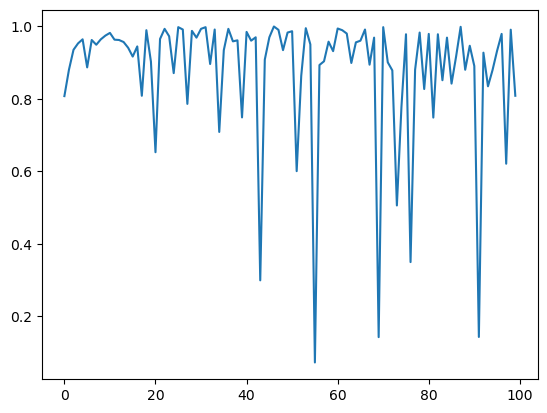

In [146]:
image = np.load("/home/ashish/Ashish/UCAN/Results/classification/Sex/Experiment_1/CV_9/AUC.npy")
import matplotlib.pyplot as plt
plt.plot(image)

In [ ]:
specificity = []
for cls in GT_class:
    cls_orig = cls.split('_')[0]
    FP = np.sum(np.array(metrics["confusion_matrix"].loc[[i for i in GT_class if i!=cls], [cls_orig + "_Pred"]]))
    TN = np.sum(np.array(metrics["confusion_matrix"].loc[[i for i in GT_class if i!=cls], [i for i in pred_class if i!=cls_orig + "_Pred"]]))
    specificity.append(TN/(TN+FP))
specificity

<Axes: >

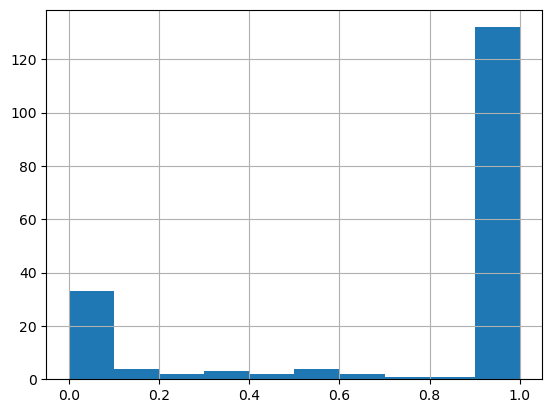

In [12]:
data["prediction_probability (diagnosis)"].hist()

### Check reshaped projections

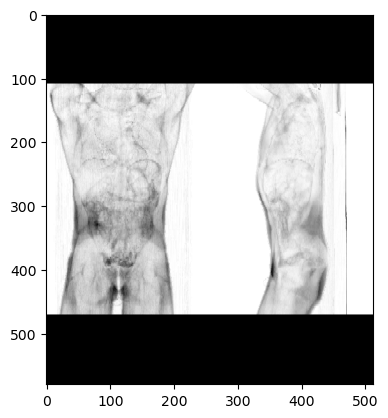

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
image = np.load("/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/lpr385705046400/20140313/CT_adipose.npy")
plt.imshow(image, cmap="gray")
plt.show()

In [3]:
path = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/lpr415675513429/20190201/"
#lpr415675513429_20190201
lst1 = ["SUV_", "CT_"]
lst2 = ["MIP.npy","bone.npy","lean.npy","adipose.npy","air.npy"]

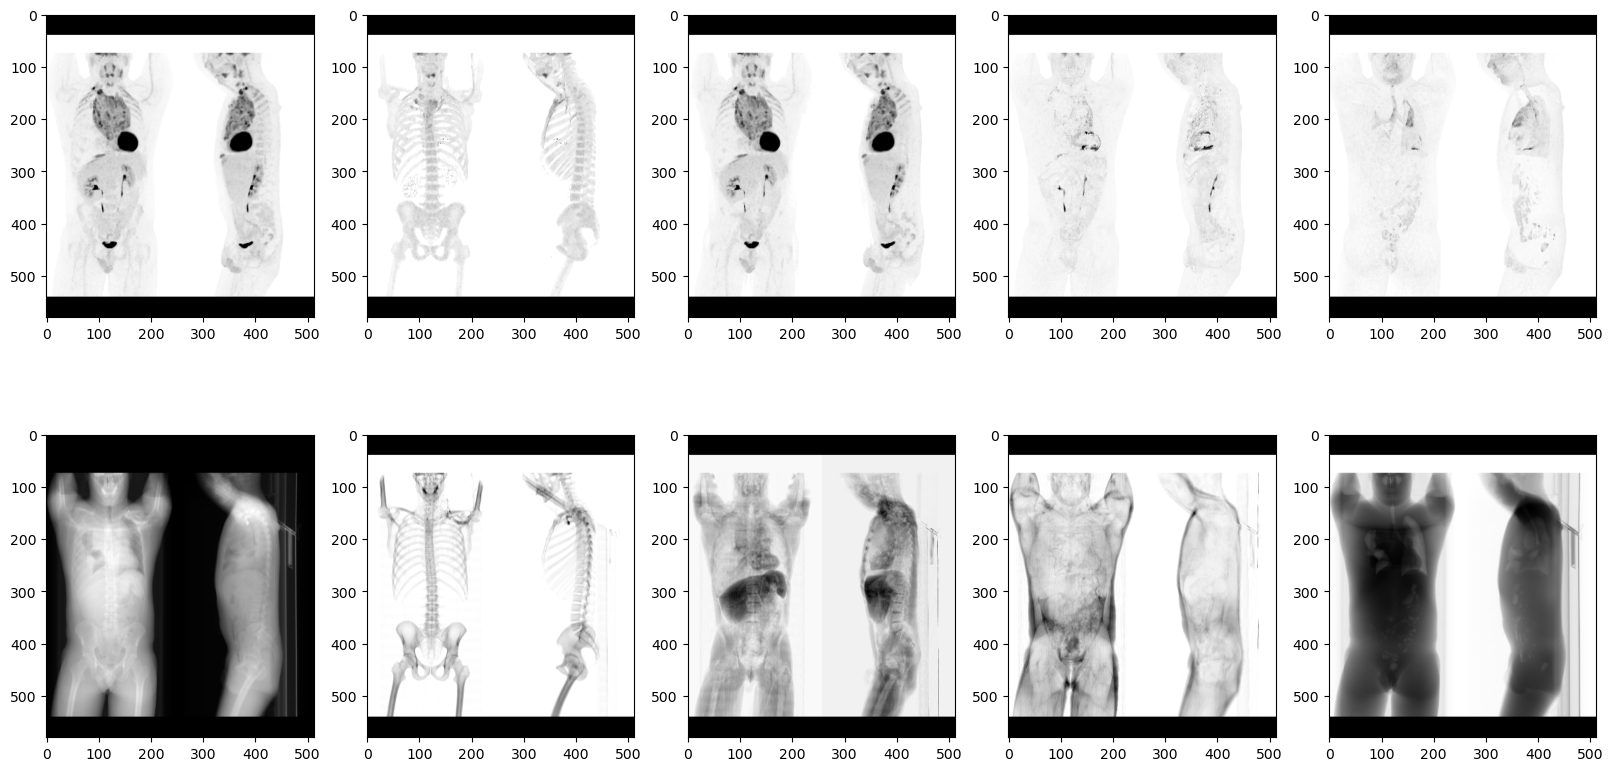

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

cv=0
for i in range(2):
    for j in range(5):
        img = np.load(path + lst1[i] + lst2[j])
        axs[i, j].imshow(img,cmap="gray")
        cv += 1
plt.show()

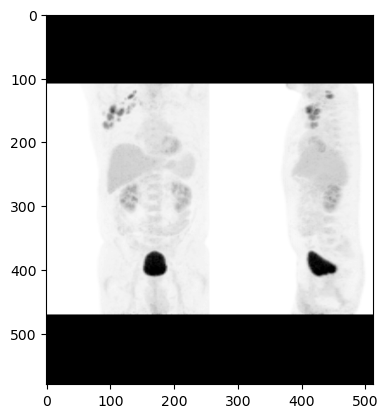

In [12]:
img = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/SUV_MIP.npy"
image_max = np.load(img)
plt.imshow(image_max, cmap="gray")
plt.show()

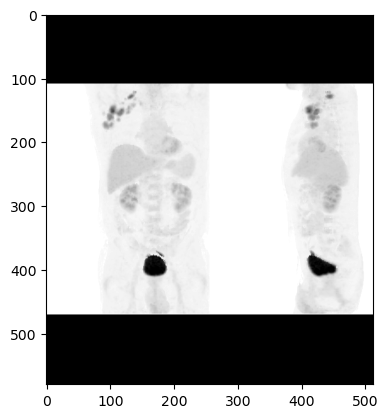

In [13]:
img = "/media/andres/T7 Shield1/UCAN_project/collages/reshaped_collages/npr113096472044/20110318/SUV_lean.npy"
image_mean = np.load(img)
plt.imshow(image_mean, cmap="gray")
plt.show()

In [14]:
(image_max == image_mean).all()

False

In [96]:
df1 = pd.read_excel(r'/home/ashish/Ashish/UCAN/Dataframes/ClinicalData/Lymphoma_Octopus_Export 2023-11-29_C80_only_n1291_incl_YYYY_MM_pnr_removed.xlsx')
df2 = pd.read_excel(r'/home/ashish/Ashish/UCAN/Dataframes/LinkedData/dataset_for_training_366patients_baseline_scans_clinical20231129.xlsx')

In [102]:
df1.translatedDiagnosis.value_counts().to_csv('/home/ashish/Ashish/UCAN/Dataframes/Analysis/clinical_data_analysis.csv')

In [103]:
df2.diagnosis.value_counts().to_csv('/home/ashish/Ashish/UCAN/Dataframes/Analysis/clinical_processed_data_analysis.csv')

In [142]:
import torch
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b7', pretrained=True)

Using cache found in /home/ashish/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


RuntimeError: Cannot find callable nvidia_efficientnet_b7 in hubconf